# Effect of History

The update data has labels perturbed according to the model's FPR. However, the initial training data is static. This means that it can be used as a sort of anchor to make sure that the model's predictions on that data do not deviate too much.

1. Preventing prediction deviation on original training set will also prevent FPR from increasing.
2. We might not trust older data as definitions of disease change over time, so we need to balance this

In [25]:
import copy
import importlib
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import importlib

import src.models.sklearn
import src.scripts.history_effect
import src.utils.data
import src.utils.metrics
import src.utils.update
import src.utils.save

importlib.reload(src.models.sklearn)
importlib.reload(src.scripts.history_effect)
importlib.reload(src.utils.data)
importlib.reload(src.utils.metrics)
importlib.reload(src.utils.update)
importlib.reload(src.utils.save)

from src.models.sklearn import lr
from src.scripts.history_effect import train_update_loop, results_to_dataframe, plot
from src.utils.data import generate_gaussian_dataset
from src.utils.metrics import eval_model
from src.utils.update import update_model_feedback_with_training, update_model_feedback_with_training_cumulative
from src.utils.save import create_file_path, save_json, CONFIG_FILE

from sklearn.model_selection import train_test_split

from dotenv import find_dotenv, load_dotenv
from settings import ROOT_DIR

%matplotlib inline

In [22]:
load_dotenv(find_dotenv(), override=True)
results_dir = os.environ.get("HISTORY_EFFECT_RESULTS_DIR")
results_dir = os.path.join(ROOT_DIR, results_dir)

## Online Update with Training Data

First we look at what happens when doing online updates that include all training data, then move on to including increasingly smaller subsets of training

In [3]:
n_train = 1000
n_update = 1000
n_test = 5000

num_features = 2

seeds = 3
num_updates = 100
train_percentages = [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

### Gaussian Data

In [12]:
data_type = "gaussian"

In [4]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

data_fn = generate_gaussian_dataset(m0, m1, s0, s1, p0, p1)

#### Temporal

In [5]:
results_non_cumulative = train_update_loop(n_train, n_update, n_test, update_model_feedback_with_training, num_updates, num_features, train_percentages, data_fn, seeds)

0
1
2


In [7]:
data_non_cumulative = results_to_dataframe(results_non_cumulative, train_percentages, seeds)

In [13]:
config = {"m0": m0, "m1": m1, "s0": s0, "s1": s1, "p0": p0, "p1": p1, "n_train": n_train, "n_update": n_update, "n_test": n_test, "num_features": num_features, "seeds": seeds,
         "num_updates": num_updates, "train_percentages": train_percentages, "data_type": data_type}

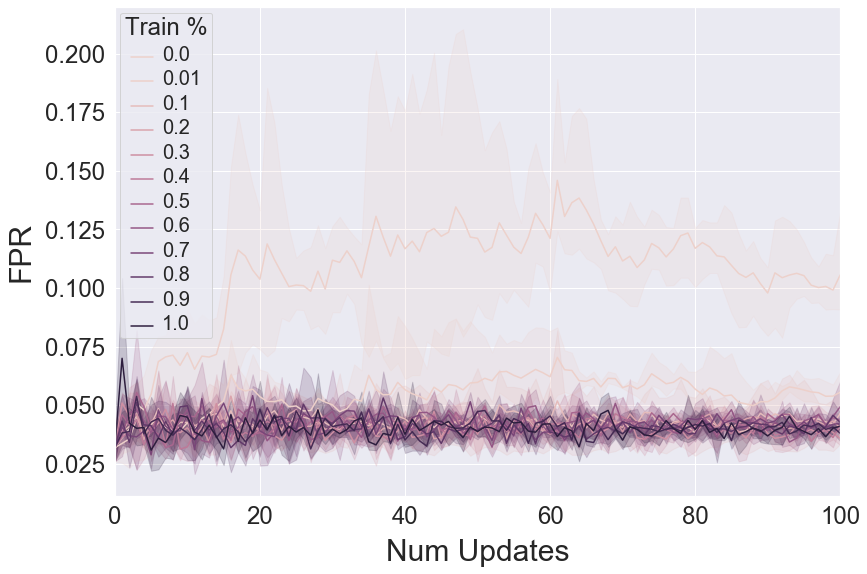

In [27]:
plot_name = "update_fpr_non_cumulative_{}".format(data_type)
plot_file_name = "{}_{}".format(plot_name, "")
plot_path = os.path.join(results_dir, plot_file_name)

create_file_path(plot_path)
plot(data_non_cumulative, num_updates, train_percentages, plot_path)

config_file_name = CONFIG_FILE.format(plot_name, "")
config_path = os.path.join(results_dir, config_file_name)
save_json(config, config_path)

## Cumulative Online Update with Training Data

### Gaussian Data

In [28]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

data_fn = generate_gaussian_dataset(m0, m1, s0, s1, p0, p1)

In [29]:
results_cumulative = train_update_loop(n_train, n_update, n_test, update_model_feedback_with_training_cumulative, num_updates, num_features, train_percentages, data_fn, seeds)

0
1
2


In [34]:
data_cumulative = results_to_dataframe(results_cumulative, train_percentages, seeds)

In [35]:
data_cumulative = pd.DataFrame(data_cumulative)

In [36]:
config = {"m0": m0, "m1": m1, "s0": s0, "s1": s1, "p0": p0, "p1": p1, "n_train": n_train, "n_update": n_update, "n_test": n_test, "num_features": num_features, "seeds": seeds,
         "num_updates": num_updates, "train_percentages": train_percentages, "data_type": data_type}

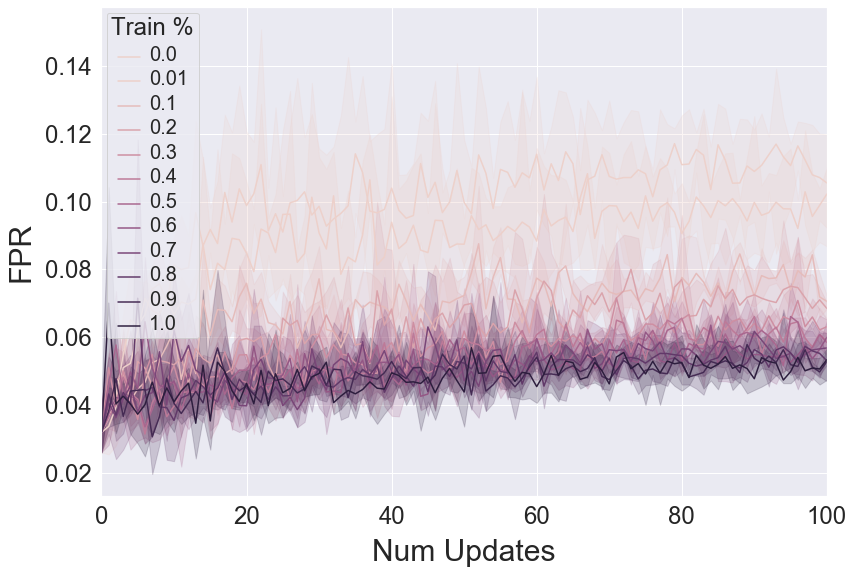

In [37]:
plot_name = "update_fpr_cumulative_{}".format(data_type)
plot_file_name = "{}_{}".format(plot_name, "")
plot_path = os.path.join(results_dir, plot_file_name)

create_file_path(plot_path)
plot(data_cumulative, num_updates, train_percentages, plot_path)

config_file_name = CONFIG_FILE.format(plot_name, "")
config_path = os.path.join(results_dir, config_file_name)
save_json(config, config_path)